In [1]:
import arviz as az
import pandas as pd
import seaborn as sns
import numpy as np
import tracemalloc
import edward as ed 
from numpy import array
import tensorflow as tf
from numpy import random
from IPython import display
from datetime import datetime
import matplotlib.pyplot as plt
from edward.util import Progbar
from edward.models import Normal, Empirical,Gamma
from sklearn import preprocessing
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

import warnings 
warnings.filterwarnings('ignore')

C:\Users\omphe\Anaconda3\lib\site-packages\distributed\utils.py:128: RuntimeWarning: Couldn't detect a suitable IP address for reaching '8.8.8.8', defaulting to '127.0.0.1': [WinError 10051] A socket operation was attempted to an unreachable network
  % (host, default, e), RuntimeWarning)
C:\Users\omphe\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:458: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\omphe\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:459: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\omphe\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:460: FutureWarning: Passing (type,

In [2]:
df_covd = pd.read_csv('daily_cases.csv')

In [3]:
df_covd.tail(7)

,date,Afghanistan,Albania,Algeria,Andorra,Angola,Anguilla,Antigua and Barbuda,Argentina,Armenia,...,Uruguay,Uzbekistan,Vanuatu,Vatican,Venezuela,Vietnam,Yemen,Zambia,Zimbabwe,World_daily_cases
425,2021-03-01,19.0,764.0,163.0,23.0,47.0,0.0,39.0,4658.0,158.0,...,595.0,0.0,0.0,0.0,429.0,0.0,25.0,468.0,26.0,306214.0
426,2021-03-02,26.0,892.0,175.0,19.0,28.0,0.0,0.0,6653.0,240.0,...,582.0,35.0,0.0,0.0,389.0,27.0,32.0,555.0,33.0,310463.0
427,2021-03-03,11.0,851.0,163.0,40.0,41.0,0.0,0.0,7855.0,360.0,...,903.0,74.0,0.0,0.0,449.0,7.0,21.0,533.0,31.0,440781.0
428,2021-03-04,5.0,847.0,168.0,28.0,58.0,0.0,44.0,7432.0,491.0,...,871.0,0.0,0.0,0.0,577.0,6.0,12.0,597.0,44.0,452910.0
429,2021-03-05,52.0,780.0,187.0,22.0,45.0,0.0,0.0,7891.0,442.0,...,984.0,46.0,0.0,0.0,396.0,6.0,36.0,654.0,25.0,446614.0
430,2021-03-06,13.0,777.0,156.0,21.0,29.0,0.0,0.0,4860.0,508.0,...,1081.0,44.0,0.0,0.0,529.0,7.0,33.0,670.0,12.0,436657.0
431,2021-03-07,7.0,819.0,130.0,23.0,31.0,0.0,35.0,2922.0,422.0,...,827.0,51.0,0.0,0.0,453.0,11.0,29.0,410.0,11.0,346607.0


In [4]:
df_covd = df_covd[['date','World_daily_cases']]

In [5]:
df_covd['date'] = pd.to_datetime(df_covd['date'])

In [6]:
df_covd['year'] = df_covd['date'].dt.year
df_covd['month'] = df_covd['date'].dt.month
df_covd['day'] = df_covd['date'].dt.day

In [7]:
df_covd.tail(3)

,date,World_daily_cases,year,month,day
429,2021-03-05,446614.0,2021,3,5
430,2021-03-06,436657.0,2021,3,6
431,2021-03-07,346607.0,2021,3,7


In [8]:
X = df_covd[['day','month','year']]
y = df_covd['World_daily_cases']

In [9]:
y.tail()

427    440781.0
428    452910.0
429    446614.0
430    436657.0
431    346607.0
Name: World_daily_cases, dtype: float64

In [10]:
Y = preprocessing.scale(y)
Y[427:]

array([0.7695709 , 0.82377454, 0.79563816, 0.75114104, 0.34871399])

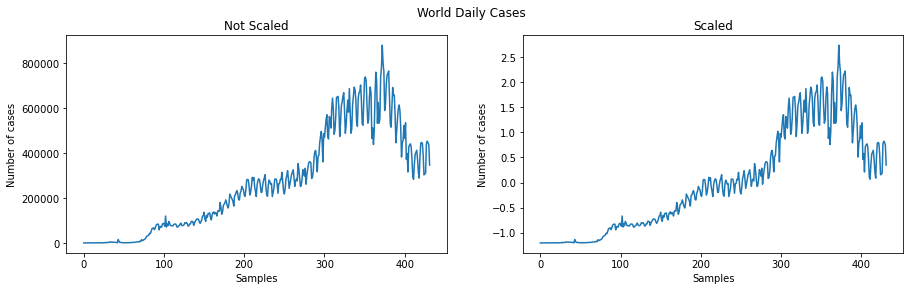

In [11]:
plt.figure(figsize=(15,4))
plt.subplot(1,2,1)
plt.title('Not Scaled')
plt.xlabel('Samples')
plt.ylabel('Number of cases')
plt.plot(y)

plt.subplot(1,2,2)
plt.title('Scaled')
plt.xlabel('Samples')
plt.ylabel('Number of cases')
plt.plot(Y)

plt.suptitle('World Daily Cases')
plt.show()

In [12]:
X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size=0.20)

In [13]:
X_train = X_train.values.reshape((345,1,3))
X_test = X_test.values.reshape((87,1,3))
Y_train = np.reshape(Y_train,(345,1,1))
Y_test = np.reshape(Y_test,(87,1,1))

In [14]:
batch_size = X_train.shape[0]
time_size = X_train.shape[1]

dtype = tf.float32
D = 3 #input_dimensions
H = 16 # Number of Hidden layers

In [15]:
tracemalloc.start()

with tf.variable_scope('model', reuse=True):
    
    W_xh = Normal(loc=tf.zeros([D, H]), scale=tf.ones([D, H]))
    W_hh = Normal(loc=tf.zeros([H, H]), scale=tf.ones([H, H]))

    W_xr = Normal(loc=tf.zeros([D, H]), scale=tf.ones([D, H]))
    W_hr = Normal(loc=tf.zeros([H, H]), scale=tf.ones([H, H]))

    W_xz = Normal(loc=tf.zeros([D, H]), scale=tf.ones([D, H]))
    W_hz = Normal(loc=tf.zeros([H, H]), scale=tf.ones([H, H]))
    
    W_y = Normal(loc=tf.zeros([H, 1]), scale=tf.ones([H, 1]))
    
    b_h = Normal(loc=tf.zeros(H), scale=tf.ones(H))
    b_r = Normal(loc=tf.zeros(H), scale=tf.ones(H))
    b_z = Normal(loc=tf.zeros(H), scale=tf.ones(H))
    b_y = Normal(loc=tf.zeros(1), scale=tf.ones(1))
    
    T = 1000 # number of iterations 
    
    qW_xh = Empirical(params=tf.Variable(tf.random_normal([T, D, H]))) 
                   
    qW_hh = Empirical(params=tf.Variable(tf.random_normal([T, H, H])))
                   
    
    qW_xr = Empirical(params=tf.Variable(tf.random_normal([T, D, H])))
                   
    qW_hr = Empirical(params=tf.Variable(tf.random_normal([T, H, H])))
                   
    
    qW_xz = Empirical(params=tf.Variable(tf.random_normal([T, D, H]))) 
                  
    qW_hz = Empirical(params=tf.Variable(tf.random_normal([T, H, H])))
                   
    
    qW_y = Empirical(params=tf.Variable(tf.random_normal([T, H, 1])))
                  
    
    x = tf.placeholder(dtype=tf.float32, shape=(None, None, D), name='x')
    
    y = tf.placeholder(dtype=tf.float32, shape=(batch_size, 1, 1), name='y')
    
    # Put the time-dimension upfront for the scan operator
    x_t = tf.transpose(x, [1, 0, 2], name='x_t')
    
    def GRU_cell(hprev, xt):
        
        r = tf.nn.sigmoid(tf.matmul(xt,W_xr)) + tf.matmul(hprev,W_hr) + b_r
        z = tf.nn.sigmoid(tf.matmul(xt,W_xz)) + tf.matmul(hprev,W_hz) + b_z
        hhat = tf.tanh(tf.matmul(xt,W_xh)) + tf.matmul((r * hprev),W_hh) + b_h
        h = (1 - z) * hprev + z * hhat
        
        return h
    
    
    
    # A little hack (to obtain the same shape as the input matrix) to define the initial hidden state h_0
    h_0 = tf.matmul(x_t[0, :, :], tf.zeros(dtype=tf.float32, shape=(D, H)), name='h_0')


    # Perform the scan operator
    h_t_transposed = tf.scan(GRU_cell, x_t, initializer=h_0, name='h_t_transposed')

    # Transpose the result back
    h_t = tf.transpose(h_t_transposed, [1, 0, 2], name='h_t')

    # tf.map_fn(lambda h_t: tf.matmul(h_t, W_output) + b_output, h_t)

    y_pred = Normal(loc=tf.map_fn(lambda h_t: tf.nn.sigmoid(tf.matmul(h_t, W_y) + b_y), h_t), scale=1.0)

    

inference = ed.HMC({W_xh: qW_xh, W_hh: qW_hh,
                     W_xr: qW_xr, W_hr: qW_hr,
                     W_xz: qW_xz, W_hz: qW_hz,
                     W_y: qW_y}, data={x: X_train, y: Y_train})

%time inference.run(n_steps=50, step_size=2.5e-5)

current, peak = tracemalloc.get_traced_memory()
print(f"Current memory is {current/10**6} MB; Peak was {peak/10**6} MB")
tracemalloc.stop()

1000/1000 [100%] ██████████████████████████████ Elapsed: 119s | Acceptance Rate: 1.00015s | Acc
Wall time: 1min 59s
Current memory is 307.628272 MB; Peak was 315.243426 MB


In [16]:
sess = ed.get_session()
sess = tf.Session()
sess.run(tf.global_variables_initializer())
test1 = sess.run({W_xh: qW_xh.sample(), W_hh: qW_hh.sample(),
                  W_xr: qW_xr.sample(), W_hr: qW_hr.sample(), 
                  W_xz: qW_xz.sample(), W_hz: qW_hz.sample(),
                  W_y: qW_y.sample() },{x: X_test})

y_post = ed.copy(y_pred, {W_xh: qW_xh, W_hh: qW_hh, W_xr: qW_xr, W_hr: qW_hr,
                     W_xz: qW_xz, W_hz: qW_hz, W_y: qW_y})

#y_out = sess.run(y_post, feed_dict={x:X_test})

In [17]:
print("Mean squared error on test data:")
print(ed.evaluate('mean_squared_error', data={x: X_test, y_post: Y_test}))
print("==============================================")
print("Mean absolute error on test data:")
print(ed.evaluate('MAE', data={x: X_test, y_post: Y_test}))
print("==============================================")

Mean squared error on test data:
1.046592
Mean absolute error on test data:
0.91322947


In [18]:
epoch = 5
container = []

for i in range(epoch):
    predictions = sess.run(y_post, feed_dict={x:X_test})
    container.append(predictions)
    
predicted_sample_groups = np.asarray(container)

y = Y_test.reshape(87)
y_rep = predicted_sample_groups.reshape(-2,87)

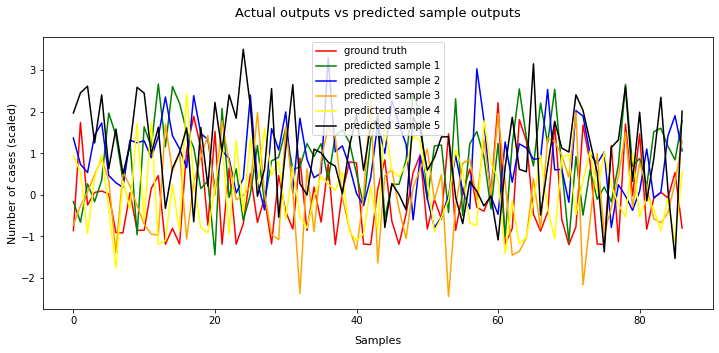

In [19]:
plt.figure(figsize=(12,5))
plt.plot(y, color='red', label='ground truth')
plt.plot(y_rep[0], color='green',label='predicted sample 1')
plt.plot(y_rep[1], color='blue', label='predicted sample 2')
plt.plot(y_rep[2], color='orange', label='predicted sample 3')
plt.plot(y_rep[3], color='yellow', label='predicted sample 4')
plt.plot(y_rep[4], color='black', label='predicted sample 5')
plt.title('Actual outputs vs predicted sample outputs', pad=20, fontsize=13)
plt.ylabel('Number of cases (scaled)', fontsize=11)
plt.xlabel('Samples', labelpad=10, fontsize=11)
plt.legend()
plt.show()

In [20]:
print("Inferred posterior mean :")
print(predicted_sample_groups.mean())
print("==============================================")
print("Inferred posterior std :")
print(predicted_sample_groups.std())
print("==============================================")

Inferred posterior mean :
0.59286886
Inferred posterior std :
1.0403972


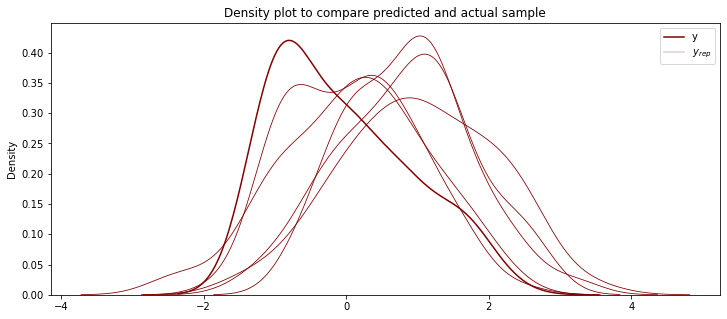

In [21]:
plt.figure(figsize=(12,5))
ed.ppc_density_plot(y, y_rep)
plt.title('Density plot to compare predicted and actual sample')
plt.show()

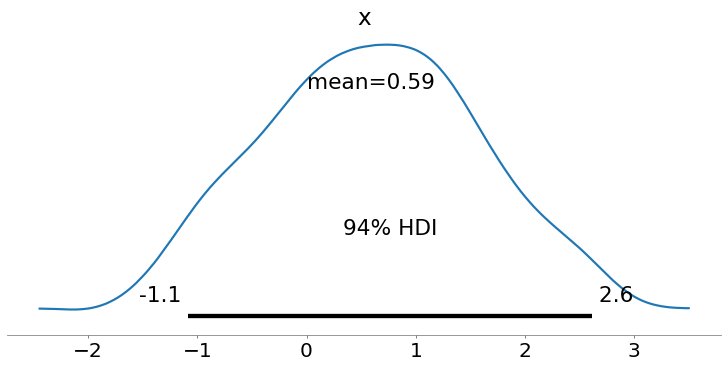

In [22]:
az.plot_posterior(y_rep, figsize=(10,5))
plt.show()

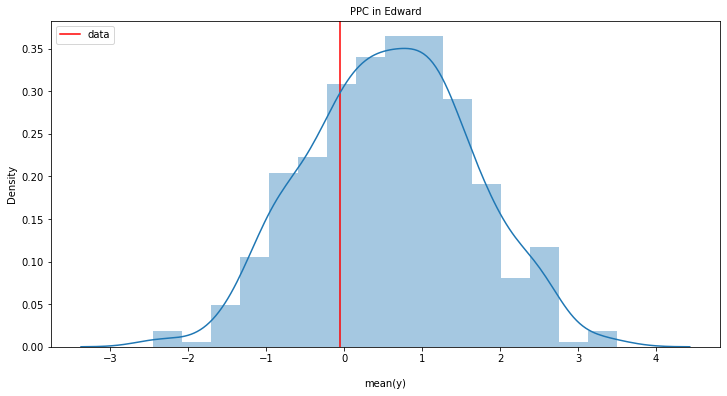

In [23]:
FONTSIZE = 10
fig, ax = plt.subplots(1, figsize=(12, 6))
ax.axvline(Y_test.mean(), color="red", label="data")
sns.distplot(y_rep)
ax.legend(loc=2, fontsize=FONTSIZE)
ax.set_xlabel("mean(y)", fontsize=FONTSIZE, labelpad=15)
_ = ax.set_title("PPC in Edward", fontsize=FONTSIZE)
plt.show()
plt.show()